<h1 style="text-align: center; font-weight: bold;">Artificial Intelligence Course - Fall 1402</h1>
<h1 style="text-align: center; font-weight: bold;">Soheil Hajian Manesh 810100119</h1>
<h1 style="text-align: center; font-weight: bold;">Computer Assignment 5 - Convoloutional Neural Network </h1>

# Problem Description
In this project, we will implement a `Convolutional Neural Network` for image classification using the PyTorch framework.The collection of images related to MRI images of the brain for the diagnosis of various brain tumors. This dataset contains different photos belonging to 4 classes, notumor, meningioma, glioma and pituitary.

In [2]:
import torch
import os
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from torch.utils.data.dataset import random_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import torch.nn.functional as F

In [13]:
file_path="../input/dataset/Dataset"

## Preprocessing
### Question 1: what are the advantages and disadvantages of image `Normalization` in image processing?
Image normalization is a common preprocessing step in Convolutional Neural Networks (CNNs). The main goal is to ensure that the input data has zero mean and unit variance, which can help the neural network converge faster and improve overall performance. Here are the advantages and disadvantages of pixel normalization:
* Advantages:
    - Improved Convergence:     
      > Normalizing pixel values helps the optimization algorithm converge faster during training.
    - Stabilized Learning:
      > Normalization helps stabilize the learning process by maintaining consistent input distributions across batches.
    - Better Generalization:
      > Normalization can improve the generalization of the model by making it less sensitive to variations in input data.
* Disadvantages:
    - Loss of Information:
      > In some cases, normalization might lead to a loss of information, especially when the original distribution of pixel values contains meaningful information for the task at hand.
    - Increased Complexity:
      > Normalization adds an extra preprocessing step to the training pipeline, potentially increasing computational complexity. However, the computational cost is generally negligible compared to the benefits gained during training.

The preprocessing includes 2 steps:
- Resize the image to 512*512
- bring the image toTensor
- normalize the image     

After that, we split data to train and test (which ratio 0.8 and 0.2).

In [14]:
class individual_dataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
        self.file_list = self._get_file_list()

    def _get_file_list(self):
        files = []
        for class_label in self.classes:
            class_path = os.path.join(self.dataset_path, class_label)
            for img_file in os.listdir(class_path):
                files.append((os.path.join(class_path, img_file), class_label))
        return files

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path, class_label = self.file_list[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.classes.index(class_label)

        if self.transform is not None:
            image = self.transform(image)

        return image, label
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = individual_dataset(dataset_path=file_path,transform=transform)


In [15]:
train_ratio=0.8

train_size = int(0.8*len(dataset))
test_size  = len(dataset)-train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


In [16]:
def classes_numbers(dataset,size):
    classes_numbers={0:0,1:0,2:0,3:0}
    for i in range(size):
        _,label = dataset.__getitem__(i)
        classes_numbers[label]+=1
    return classes_numbers

In [17]:
train_classes_numbers=classes_numbers(train_dataset,train_size)
test_classes_numbers=classes_numbers(test_dataset,test_size)

In [18]:
def plot_classes_number_of_data(dataset,title):
    class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
    values = dataset.values()

    plt.bar(class_names, values)

    plt.xlabel('Tumor Classes')
    plt.ylabel('Number of Samples')
    plt.title(title)

    plt.show()

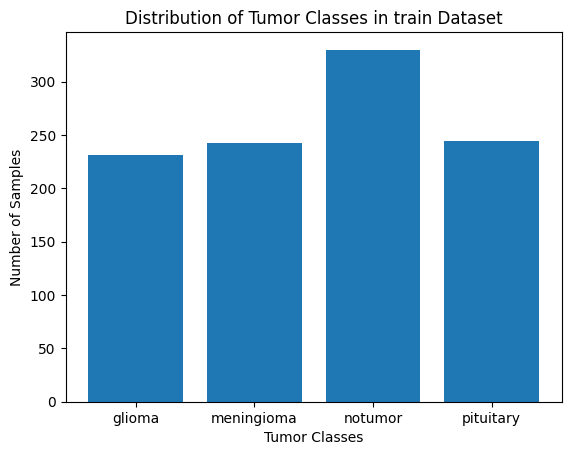

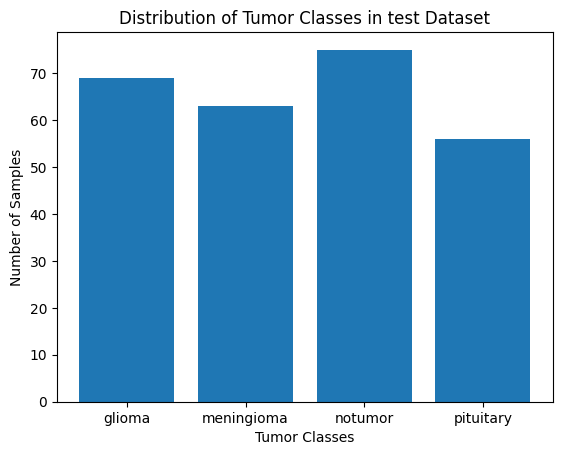

In [19]:
plot_classes_number_of_data(train_classes_numbers,title='Distribution of Tumor Classes in train Dataset')
plot_classes_number_of_data(test_classes_numbers,title='Distribution of Tumor Classes in test Dataset')

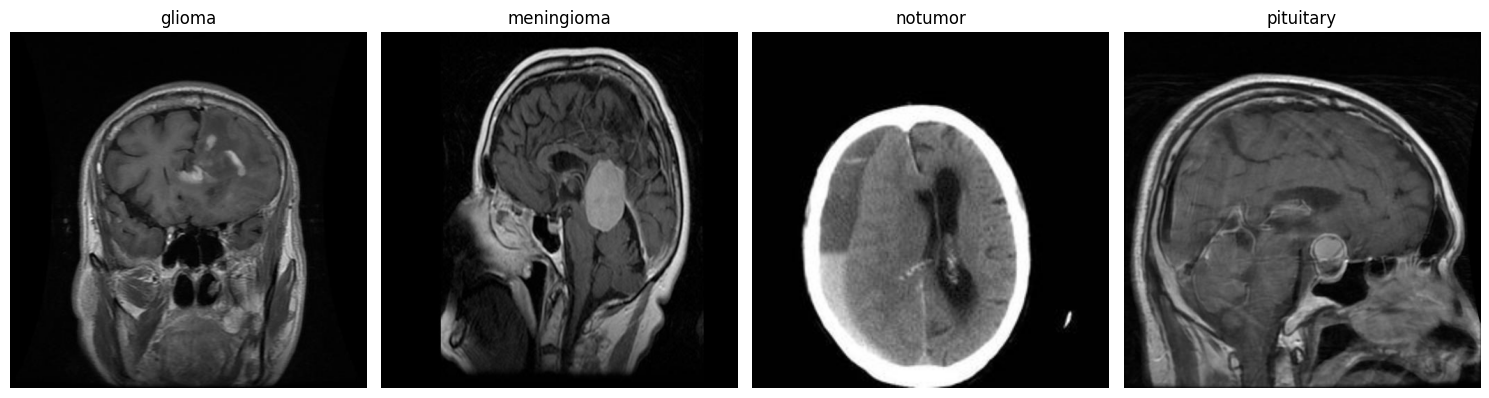

In [20]:
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
classes_image={0:None, 1:None, 2:None, 3:None}
i = 0
while None in classes_image.values():
    image , label = train_dataset.__getitem__(i)
    classes_image[label]=image
    i+=1

fig, axes = plt.subplots(1, len(dataset.classes), figsize=(15, 5))
for ax, (class_label, image) in zip(axes, classes_image.items()):
    ax.imshow(np.transpose(image, (1, 2, 0)))
    ax.set_title(class_names[class_label])
    ax.axis('off')

plt.tight_layout()
plt.show()

## Classification using CNN
- **kernel size**:   
The kernel (or filter) size specifies the dimensions of the filter window that traverses the input image to generate a single pixel in the feature map.

- **Why use different kernel sizes?**     
    `Smaller kernels` (e.g., 3x3) in a convolutional neural network capture finer details and encourage more parameter sharing, while `larger kernels` (e.g., 5x5 or 7x7) have a broader receptive field, potentially capturing more global features but with increased computational cost and risk of overfitting.
- **Stride**:   
    Stride dictates the number of pixels by which the filter window moves across the input image. A stride of 1 moves the filter one pixel at a time, resulting in dense feature mapping. A larger stride reduces the spatial dimensions of the output feature map, leading to less computation and memory usage but possibly losing some fine-grained patterns.

- **Padding**:    
    Padding involves adding layers of zeros around the border of the input image to allow the convolution operation to be applied to the bordering elements of the input image.
  - **Why use padding?**
    - To control the spatial size of the output volumes, often to maintain the same input and output dimensions.
    - To enable the network to learn features from the corners and edges of the images.

- **Number of filters in Convolutional Layers**:   
    The number of filters (kernels) in convolutional layers affects a CNN's ability to capture features.

    `More Kernels`: Enhances capacity, allows for hierarchical feature abstraction, encourages parameter sharing, and increases computational cost. Suitable for complex tasks.Too many kernels might lead to overfitting.

    `Fewer Kernels`: Reduces capacity, may limit hierarchical feature learning, reduces parameter sharing, and lowers computational cost. Suitable for simpler tasks but may lack expressiveness for complex patterns.
- **Depth of Convolutional layer**:    
    This refers to the depth of the network, the number of convolutional layers stacked together. Increasing depth can enhance the network's ability to represent complex features.

    - **Why adjust the number of layers?**
        - More layers can help the network learn a hierarchical representation of the data.
        - Too many layers might lead to overfitting and make the network harder to train, especially without sufficient data.
        - As you go deeper, the spatial size tends to decrease whereas the depth (number of filters) increases, moving from raw pixels to abstract concepts.   
- **Depth of Fully Connected layer**:    
    The impact of the depth, or the number of fully connected layers, includes:

    - `More Depth`:   
      > Provides the network with greater capacity,  increases computational complexity,  May have a higher risk of overfitting,  Requires more time and computational resources for training.
    - `less Depth`:
      > May have limited capacity to capture complex patterns and features,Is computationally more efficient, Tends to be less prone to overfitting, making it suitable for smaller datasets, Trains faster
- **Number of neurons in fully connected layers**:   
  The number of neurons in each fully connected layer of a Convolutional Neural Network (CNN) affects:
    - `More Neurons`: Increased capacity to learn complex patterns,  Higher risk of overfitting,   Higher computational cost during training,  Expresses a broader range of features and relationships.
    - `Fewer Neurons`: Limited capacity for intricate relationships, Helps mitigate overfitting, suitable for limited data,  More computationally efficient, Limits expressiveness, potentially restricting pattern capture.    
    
  In practice, the choice involves balancing model capacity, overfitting, computational efficiency, and generalization.
  
## Building a CNN:      
*   Deciding on the size of the `filters`, `stride`,and `padding` is like choosing the building blocks for your Convolutional Neural Network (CNN). It's a bit of an art and a bit of science, involving testing and tuning.

*   When you create a CNN, you often kick off with some well-known architectures like VGG or ResNet. But the key is to tuning these setups to fit your specific problem and data size. The goal is finding a good balance between making accurate predictions and doing it efficiently, all while avoiding overfitting. Experts use fancy methods like adjusting hyperparameters and trying out different architectures to make this process smoother and less hands-on.

In [36]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=8, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=4, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)


        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)


        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(127008, 64)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 64)
        self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(64, 4)

    def forward(self, x):
        x=self.conv1(x)
        x=self.bn1(x) # comment this line for non-regularization model
        x=self.relu(x)
        x = self.pool(x)

        x=self.conv2(x)
        x=self.bn2(x) # comment this line for non-regularization model
        x=self.relu(x)
        x = self.pool(x)

        x=self.conv3(x)
        x=self.bn3(x) # comment this line for non-regularization model
        x=self.relu(x)
        x = self.pool(x)

        x = self.flatten(x)
        # print(x.shape)
        x = self.relu(self.fc1(x))
        x = self.dropout1(x) # comment this line for non-regularization model
        x = self.relu(self.fc2(x))
        x = self.dropout2(x) # comment this line for non-regularization model
        x = self.fc3(x)


        return x

### Avtivation function
The purpose of an `Activation function` is to add non-linearity to the neural network.    
let’s have a look at some different non-linear neural networks activation functions and their characteristics:
1. **Sigmoide**: This function takes any real value as input and outputs values in the range of 0 to 1:   

$$f(x) = \frac{1}{1 + e^{-x}}$$
it is commonly used for models where we have to predict the probability as an output. Since probability of anything exists only between the range of 0 and 1, sigmoid is the right choice because of its range.    

2. **Tanh**: Tanh function is very similar to the sigmoid/logistic activation function, and even has the same S-shape with the difference in output range of -1 to 1:    
     
$$f(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$$   
Usually used in hidden layers of a neural network as its values lie between -1 to 1; therefore, the mean for the hidden layer comes out to be 0 or very close to it. It helps in centering the data and makes learning for the next layer much easier.    

3. **Relu**: ReLU stands for Rectified Linear Unit. 
The main catch here is that the ReLU function does not activate all the neurons at the same time. 

The neurons will only be deactivated if the output of the linear transformation is less than 0:

$$\text{ReLU}(x) = \max(0, x)$$

- Since only a certain number of neurons are activated, the ReLU function is far more computationally efficient when compared to the sigmoid and tanh functions.
- ReLU accelerates the convergence of gradient descent towards the global minimum of the loss function due to its linear, non-saturating property.

I use `Relu Actiovation Function` in my CNN  

4. **Softmax**:

 $$f(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{K} e^{x_j}}$$
  - Applied over all `K` classes for multiclass classification.
- **Properties**:
  - Outputs a probability distribution over `K` different possible outcomes.
  - Often used in the output layer for classification problems.

### nn.Conv2d Parameters:
1. `num_channels`: Number of input channels for the first convolutional layer. For RGB images, this is 3.
2. `out_channels`: Number of filters or kernels the convolutional layer will learn from the input. Here, it's set to 16, meaning there will be 16 feature maps after this layer.
3. `kernel_size`: Size of the convolution filter. A `kernel_size` of 10 means a 10x10 filter.
4. `padding`: Zero-padding added to the borders of the input matrix. Padding of 1 adds a single layer of 0s around the image, which enables the kernel to process the edges of the input image.
5. `stride`:Stride dictates the number of pixels by which the filter window moves across the input image.stride of 1 means filter moves 1 pixel across the input image in each movement.    

### nn.AvgPool2d:
1. `kernel_size`: Specifies the dimensions of the window used for averaging. In this instance, it is set to 2x2, resulting in a halving of the height and width of the feature maps.
2. `stride`: Determines the step size of the pooling window during each operation. In this scenario, a value of 2 signifies non-overlapping pooled regions.     

### Fully connected layers - nn.Linear:    
1. `in_features`: Represents the number of neurons in the hidden layer of the fully connected section. It is initially set to 256 and serves as a hyperparameter that can be fine-tuned.In first fc it should set to flatten output.
2. `out_features`: Indicates the size of the output layer, corresponding to the number of classes in a classification task. In this case, it's set to 4 for last fc because we have 4 image class.


### Forwarding:
The `forward` method defines the flow of data through the network. The input x undergoes 3 convolutional layers, followed by flattening to align with the dimensionality expected by the fully connected layers. Subsequently, it traverses 3 linear layers to generate the final output.

**effect of changing these parameters on model:**
1. Increasing `num_channels`: This is typically based on the input data (e.g., RGB images have 3 channels, grayscale has 1). Changing it arbitrarily won't make sense.
2. More `out_channels`: More filters capture additional features but increase computational cost and model complexity.
3. Larger `kernel_size`: Larger kernels capture more context but reduce feature map size more drastically.
4. Increasing `padding`: Helpful to preserve feature map size, can lead to better edge feature extraction; too much padding can dilute feature intensity.
5. More `in_features`: A higher number allows the network to learn more complex patterns but may lead to overfitting and increased computational costs.
6. Changing `out_features`: It's based on the number of output classes you have; changing it otherwise will mismatch the problem's requirements.

### Number of layers:
Including more layers enables the network to learn deeper, but it may also cause overfitting and higher computational requirements. Striking the right balance is essential, guided by cross-validation results.

## Adam Optimizer
`Adam` is an optimization algorithm that can be used instead of the classical stochastic gradient descent(SGD) procedure to update network weights iterative based in training data.    
`Stochastic gradient descent` maintains a single learning rate (termed alpha) for all weight updates and the learning rate does not change during training.
In summary, `Adam` is an adaptive optimization algorithm that dynamically adjusts learning rates for each parameter based on the history of gradients. Its incorporation of both first and second-order moments, along with bias correction, can lead to faster and more effective training compared to traditional SGD, especially in scenarios with varying gradient magnitudes. However, the choice between Adam and SGD may depend on factors such as the dataset, architecture, and computational resources.    
#### Adam vs. SGD:
While the standard SGD updates weights by taking a step proportional only to the average of the recent gradients (optionally, with a momentum term), Adam modifies this process by scaling the step size for each weight based on the historical squared gradients (the variance).

Main differences include:

1. **Adaptive Learning Rates**: SGD maintains a single learning rate (step size) for all weight updates which doesn't change. Adam computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients.
2. **Momentum**: While momentum can be used alongside SGD, Adam has it incorporated by design. In Adam, the accumulation of past gradients furnishes a momentum effect, smoothing the optimization process.
3. **Bias Correction**: Because Adam calculates adaptive learning rates based on running averages that start out as zero, it includes a bias correction mechanism to compensate for this early underestimation.   

#### Choosing Adam for Optimization:

Adam serves as a common choice for the default optimizer in many deep learning tasks due to several factors:

- It often requires minimal hyperparameter tuning, with default values (alpha=0.001, beta1=0.9, beta2=0.999, and epsilon=10^-7) proving effective in many scenarios.
- It combines the advantages of other optimization techniques, making it suitable for a wide range of problems and data modalities.
- It exhibits lower sensitivity to gradient scale variations, making it advantageous for models and problems with diverse gradient magnitudes.    

Adam is particularly favored in situations demanding swift and efficient convergence, especially when dealing with extensive datasets or high-parameter models like deep learning architectures. However, it's worth noting that in some instances, SGD may converge to a superior or more stable solution given ample time and meticulous tuning of the learning rate schedule. Recent studies suggest that in certain cases, models trained with SGD might generalize better than those trained with Adam, emphasizing the absence of a one-size-fits-all solution.      

Ultimately, the choice of optimizer is another hyperparameter to tune, and considering computational efficiency, ease of use, and empirical performance on the validation set should inform the decision.







In [25]:
model1 = CNN()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)

# Loss function
1. **Mean Squared Error Loss (torch.nn.MSELoss)**:
    - Usage: Typically used for regression tasks where the goal is to minimize the mean squared difference between predicted and true continuous values.
2. **Cross-Entropy Loss (torch.nn.CrossEntropyLoss)**:
    - Usage: Commonly used for multi-class classification tasks. It combines the softmax activation and negative log-likelihood loss in one single class.
3. **Binary Cross-Entropy Loss (torch.nn.BCELoss)**:
    - Usage: Used for binary classification tasks, where each example belongs to one of two classes (0 or 1).
4. **Binary Cross-Entropy Loss with Logits (torch.nn.BCEWithLogitsLoss)**:
    - Usage: Similar to Binary Cross-Entropy Loss but more numerically stable when working directly with logits.
5. **Huber Loss (torch.nn.SmoothL1Loss)**:
    - Usage: Used for regression tasks as an alternative to Mean Squared Error Loss. It is less sensitive to outliers.
6. **Poisson Negative Log-Likelihood Loss (torch.nn.PoissonNLLLoss)**:
    - Usage: Appropriate for tasks where the target values follow a Poisson distribution (e.g., count data).    
    
These are just a few examples of the many loss functions available in PyTorch. The choice of the appropriate loss function depends on the specific requirements of the task at hand.            

In this case we use `Cross-Entropy Loss Function` because we have 4 image class that is multi-class classification tasks.

In [26]:
criterion = nn.CrossEntropyLoss()

## Training Model

### Batch size
The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters. When training a neural network, it’s not feasible or efficient to update the model’s weights with every sample (online learning) or after going through the entire dataset (because of the computational burden and memory constraints).     
So, training often occurs using mini-batches.    

#### Effects of Batch Size on Training:

1. Memory Usage:
> Smaller batches use less memory and work well with limited resources.
Larger batches need more memory but can benefit from optimized computations.    
2. Model Performance and Learning:    
> Smaller batches introduce some randomness, possibly aiding generalization but making training less stable. Larger batches offer stable training but might lead to poorer generalization.
3. Computational Efficiency:
> Smaller batches explore the error landscape thoroughly but might take longer to converge.
Larger batches may take longer per iteration but could require fewer iterations for convergence.
4. Convergence Speed:    
> Smaller batches can escape local minima due to gradient noise, leading to potentially better solutions.
Larger batches may get stuck in local minima due to a smoothing effect.    
5. Use of Parallelism:
> Larger batches can take advantage of parallel processing for faster training on multi-core CPUs or GPUs.


In [27]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [28]:
def train_loop(model, criterion, optimizer, train_loader, test_loader, num_epochs=10):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)

            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.2f}, Train Accuracy: {train_accuracy:.2f}')

        model.eval()
        running_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

            test_loss = running_loss / len(test_loader)
            test_accuracy = correct_test / total_test
            test_losses.append(test_loss)
            test_accuracies.append(test_accuracy)

            print(f'Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}')
    return  train_losses,test_losses,train_accuracies,test_accuracies

In [29]:
train_losses,test_losses,train_accuracies,test_accuracies=train_loop(model1, criterion, optimizer1, train_loader, test_loader, num_epochs=10)

Epoch 1/10, Train Loss: 1.20, Train Accuracy: 0.44
Test Loss: 0.86, Test Accuracy: 0.64
Epoch 2/10, Train Loss: 0.77, Train Accuracy: 0.70
Test Loss: 0.58, Test Accuracy: 0.79
Epoch 3/10, Train Loss: 0.60, Train Accuracy: 0.76
Test Loss: 0.52, Test Accuracy: 0.81
Epoch 4/10, Train Loss: 0.45, Train Accuracy: 0.83
Test Loss: 0.51, Test Accuracy: 0.81
Epoch 5/10, Train Loss: 0.34, Train Accuracy: 0.88
Test Loss: 0.44, Test Accuracy: 0.83
Epoch 6/10, Train Loss: 0.28, Train Accuracy: 0.90
Test Loss: 0.42, Test Accuracy: 0.84
Epoch 7/10, Train Loss: 0.17, Train Accuracy: 0.94
Test Loss: 0.47, Test Accuracy: 0.84
Epoch 8/10, Train Loss: 0.10, Train Accuracy: 0.97
Test Loss: 0.43, Test Accuracy: 0.87
Epoch 9/10, Train Loss: 0.06, Train Accuracy: 0.98
Test Loss: 0.51, Test Accuracy: 0.84
Epoch 10/10, Train Loss: 0.04, Train Accuracy: 0.99
Test Loss: 0.54, Test Accuracy: 0.87


In [30]:
def plot_epoch_scale(train_scales, test_scales, train_title, test_title, ylabel, title):
    plt.figure(figsize=(10, 5))
    plt.plot(train_scales, label=train_title)
    plt.plot(test_scales, label=test_title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.title(title)
    plt.show()


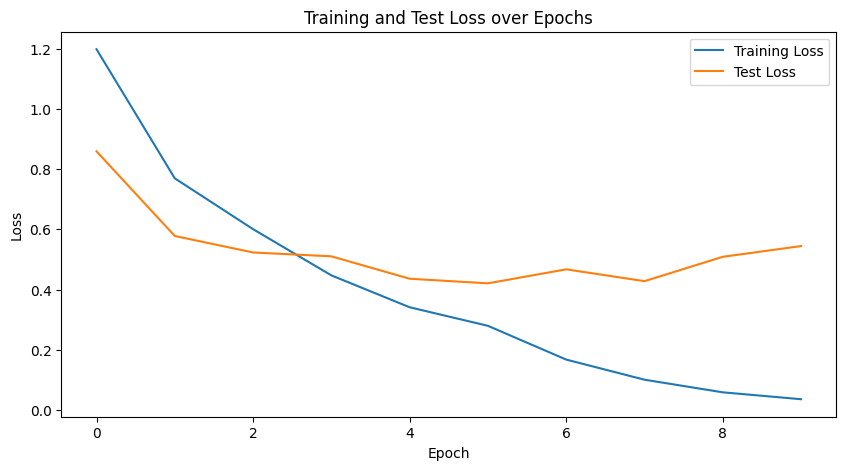

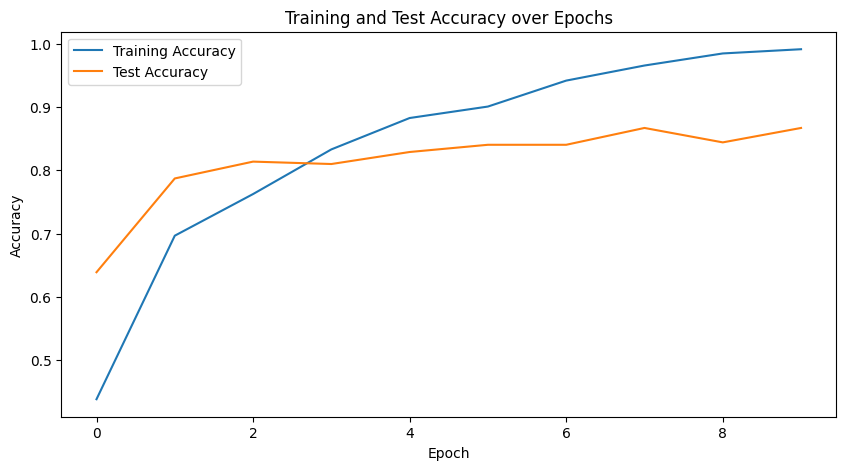

In [31]:
plot_epoch_scale(train_losses,test_losses,'Training Loss','Test Loss','Loss','Training and Test Loss over Epochs')
plot_epoch_scale(train_accuracies,test_accuracies,'Training Accuracy','Test Accuracy','Accuracy','Training and Test Accuracy over Epochs')

As you can see despite achieving high accuracy on both the training and test datasets, it is evident that the model is overfitting. The accuracy for the training data reaches 99% after 10 epochs, indicating strong performance on the training set. However, this success does not extend seamlessly to unseen data, as the accuracy on the test data is only 87% at epoch 10. Moreover, the loss value is increasing, suggesting that if more epochs are added, the accuracy for the test data is likely to decrease. This discrepancy between training and test accuracies implies a need for caution in extending the model's performance to new, unseen datasets.

## Regularization

`Dropout` and `Batch Normalization` are important techniques in training deep neural networks. They address different issues and can be applied independently or together. Below is an overview of each method's purpose and performance impacts when used in neural networks.      
### Dropout:
`Dropout` is a regularization method used in neural networks, including CNNs, where a random fraction of neurons is temporarily removed during training.

**Performance on CNNs**:
1. `Regularization`: Mitigates overfitting by discouraging reliance on specific neurons.
2. `Robust Feature Learning`: Promotes the learning of more independent and robust features.
3. `Training Time`: Can increase training time since it often requires more epochs for convergence.
4. `Reduced Sensitivity`: Decreases sensitivity to individual neurons, improving adaptability.
5. `Inference Time`: No impact since dropout is only applied during training, not during inference.
**Considerations**:  

Careful adjustment of dropout rate is necessary for optimal performance.     
Impact may vary based on architecture and task characteristics.    
Common values for dropout probability range from 0.2 to 0.5.


### Batch Normalization:
`Batch Normalization` (BN) is a technique that stabilizes and speeds up the learning process by normalizing the inputs of each layer. By adjusting and scaling the activations, it ensures that the distribution of the inputs to a layer doesn't change too much, which can prevent issues like the vanishing or exploding gradient problems.

1. **Performance on CNNs**:
1. `Training Speed`: Typically makes the network faster to train. It allows for the use of higher learning rates and reduces the sensitivity to initialization.
2. `Convergence`: Networks often converge quicker with batch normalization.
3. `Model Performance`: Can improve model performance, as it has a slight regularization effect.
4. `Inference Time`: Can slightly increase inference time as there are extra computations for normalization; however, this can be mitigated by folding BN into the preceding layers during optimization.

In [37]:
model2 = CNN()
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

In [38]:
train_losses_2,test_losses_2,train_accuracies_2,test_accuracies_2=train_loop(model2, criterion, optimizer2, train_loader, test_loader, num_epochs=10)

Epoch 1/10, Train Loss: 1.59, Train Accuracy: 0.44
Test Loss: 1.24, Test Accuracy: 0.39
Epoch 2/10, Train Loss: 0.95, Train Accuracy: 0.60
Test Loss: 0.89, Test Accuracy: 0.62
Epoch 3/10, Train Loss: 0.82, Train Accuracy: 0.69
Test Loss: 0.59, Test Accuracy: 0.78
Epoch 4/10, Train Loss: 0.67, Train Accuracy: 0.72
Test Loss: 0.66, Test Accuracy: 0.75
Epoch 5/10, Train Loss: 0.61, Train Accuracy: 0.74
Test Loss: 0.60, Test Accuracy: 0.76
Epoch 6/10, Train Loss: 0.52, Train Accuracy: 0.79
Test Loss: 0.63, Test Accuracy: 0.78
Epoch 7/10, Train Loss: 0.38, Train Accuracy: 0.84
Test Loss: 0.52, Test Accuracy: 0.81
Epoch 8/10, Train Loss: 0.37, Train Accuracy: 0.85
Test Loss: 0.58, Test Accuracy: 0.76
Epoch 9/10, Train Loss: 0.34, Train Accuracy: 0.85
Test Loss: 0.52, Test Accuracy: 0.77
Epoch 10/10, Train Loss: 0.29, Train Accuracy: 0.87
Test Loss: 0.46, Test Accuracy: 0.83


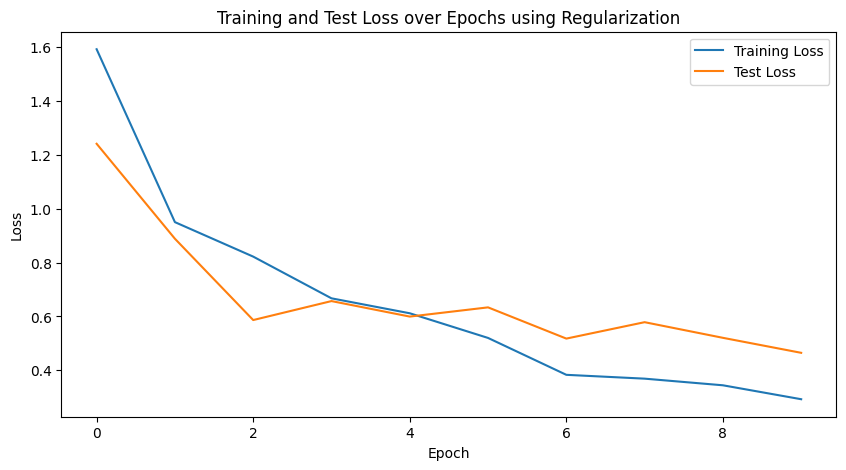

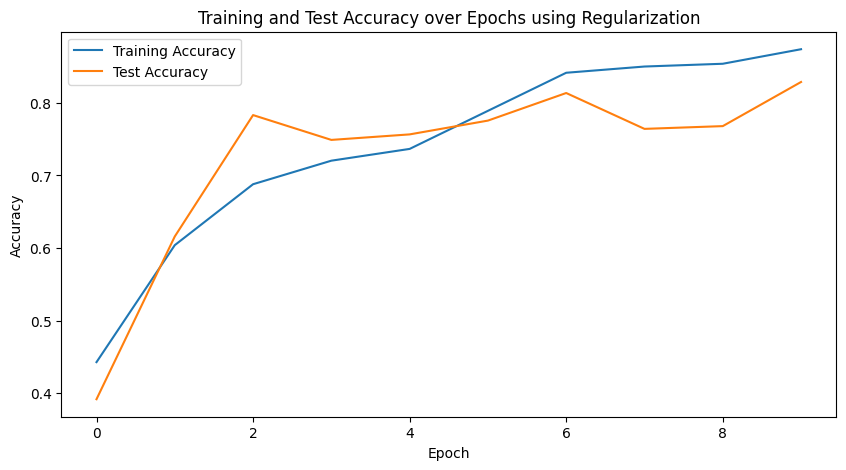

In [39]:
plot_epoch_scale(train_losses_2,test_losses_2,'Training Loss','Test Loss','Loss','Training and Test Loss over Epochs using Regularization')
plot_epoch_scale(train_accuracies_2,test_accuracies_2,'Training Accuracy','Test Accuracy','Accuracy','Training and Test Accuracy over Epochs using Regularization')

After implementing regularization on the model, the training accuracy has decreased compared to the previous model, but it remains satisfactory. The test accuracy is also commendable, reaching 83% after 10 epochs. Notably, the difference between the accuracies of the test and training sets is minimal, indicating that the model avoids overfitting and performs well on both datasets. Additionally, the loss values consistently decrease with each epoch for both training and test data.

In [42]:
def plot_confusion_matrix(conf_matrix,class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [43]:
def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_predictions, labels=range(len(class_names)))

    print('Metrics for each class:')
    for i, class_name in enumerate(class_names):
        class_indices = [j for j, label in enumerate(all_labels) if label == i]
        accuracy_class = accuracy_score([all_labels[j] for j in class_indices], [all_predictions[j] for j in class_indices])

        print(f'  Class: {class_name}')
        print(f'    Accuracy: {accuracy_class:.2f}')
        print(f'    Precision: {precision[i]:.2f}')
        print(f'    Recall: {recall[i]:.2f}')
        print(f'    F1 Score: {f1[i]:.2f}')
        print()

    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='macro')
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    print('Metrics for all classes:')
    print(f'  Overall Accuracy: {accuracy:.2f}')
    print(f'  Overall Precision: {precision:.2f}')
    print(f'  Overall Recall: {recall:.2f}')
    print(f'  Overall F1 Score: {f1:.2f}')
    
    plot_confusion_matrix(conf_matrix,class_names)

### Model1(without Regularization) Metrics and confusion matrix:

Metrics for each class:
  Class: glioma
    Accuracy: 0.81
    Precision: 0.89
    Recall: 0.81
    F1 Score: 0.85

  Class: meningioma
    Accuracy: 0.75
    Precision: 0.77
    Recall: 0.75
    F1 Score: 0.76

  Class: notumor
    Accuracy: 0.96
    Precision: 0.94
    Recall: 0.96
    F1 Score: 0.95

  Class: pituitary
    Accuracy: 0.95
    Precision: 0.85
    Recall: 0.95
    F1 Score: 0.90

Metrics for all classes:
  Overall Accuracy: 0.87
  Overall Precision: 0.86
  Overall Recall: 0.87
  Overall F1 Score: 0.86


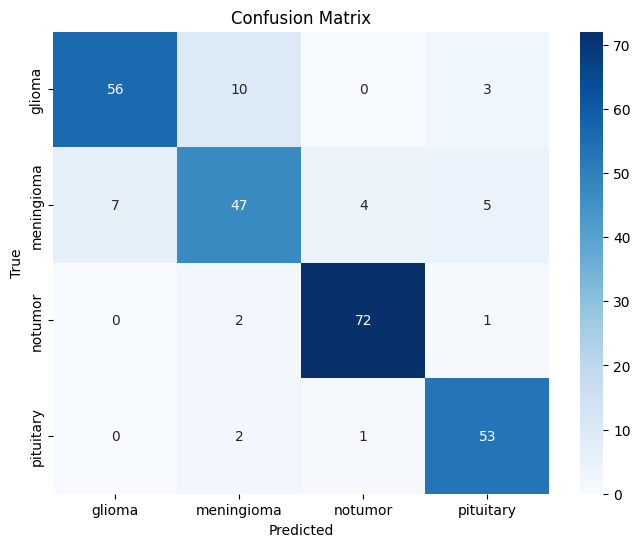

In [44]:
evaluate_model(model1, test_loader, class_names)


### Model2(with Regularization) Metrics and confusion matrix:

Metrics for each class:
  Class: glioma
    Accuracy: 0.74
    Precision: 0.85
    Recall: 0.74
    F1 Score: 0.79

  Class: meningioma
    Accuracy: 0.71
    Precision: 0.67
    Recall: 0.71
    F1 Score: 0.69

  Class: notumor
    Accuracy: 0.92
    Precision: 0.91
    Recall: 0.92
    F1 Score: 0.91

  Class: pituitary
    Accuracy: 0.95
    Precision: 0.88
    Recall: 0.95
    F1 Score: 0.91

Metrics for all classes:
  Overall Accuracy: 0.83
  Overall Precision: 0.83
  Overall Recall: 0.83
  Overall F1 Score: 0.83


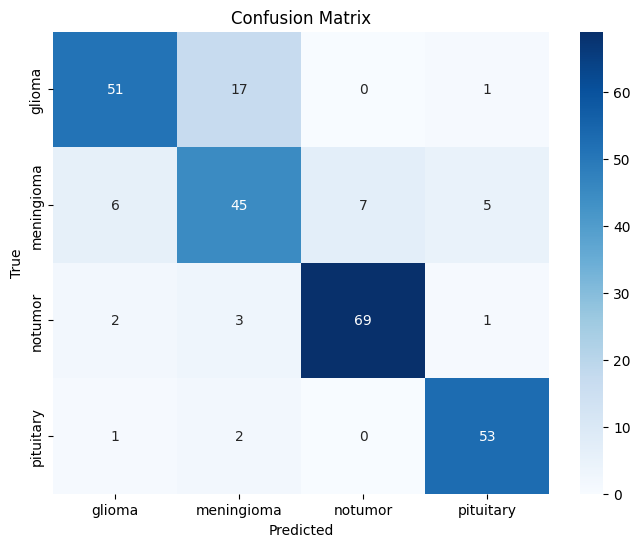

In [45]:
evaluate_model(model2, test_loader, class_names)

While model1 exhibits signs of overfitting, it demonstrates superior performance on our dataset. However, model2 appears to be more stable. This stability is evident when considering an increase in the number of epochs. Model1 may experience a decline in performance on the test data, whereas model2 maintains consistent performance on both the training and test datasets.

Noteworthy is the observation that the accuracy of the `notumor` class stands out as the highest, reflected in the boldest color in the confusion matrix. In contrast, the `meningioma` class exhibits the lowest accuracy among all classes."